# Imports

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import importlib
import seaborn as sns
import gc  # garbage collector
import os

from typing import List

import utils as dp  # own functions and logic
importlib.reload(dp)  # this makes it so that 
                      # the file with our functions is re-read every time, 
                      # in case we have made modifications

<module 'utils' from '/home/andreas/Nextcloud/Dokumente/Uni/Module/3sem-EPFL/ada/Project/ada-2024-project-thedataminions/analysis/utils.py'>

# Configure path to data files

In [31]:
# define the path to the folder where the YouNiverse dataset is stored here

# when adding your own path, don't remove the existing path, just comment it
# in this way, everyone can quickly uncomment their own path
dataset_root_path = "/media/andreas/Backup Plus/Ada/youniverse_dataset/"   #andreas
#dataset_root_path = "D:/ada_project/dataset/"                                    #mila
# dataset_root_path = "/Volumes/DISQUE_SAUVEGARDE_MANON_LANDRIEUX/dataset/"  #manon
# dataset_root_path = "/Volumes/Backup/Youniverse_dataset/" #Lou-Anne 

# Preprocessing

## Loading the data

In [32]:
# load channel data (no chunks needed, as the file is not very large)
df_channels = pd.read_csv(dataset_root_path + "df_channels_en.tsv.gz", compression="infer", sep="\t") #andreas 
#df_channels = pd.read_csv(dataset_root_path + "df_channels_en.tsv", compression="infer", sep="\t") # manon 

In [33]:
# load a small part of video and comment data, to try functions on them etc.
# these datasets should not be used for calculations, as they don't contain all the data

# load (first 100000 rows of) video data
df_videos = pd.read_json(dataset_root_path + "yt_metadata_en.jsonl.gz", compression="infer", lines=True, nrows=100000) #andreas 
#df_videos = pd.read_json(dataset_root_path + "yt_metadata_en.jsonl", compression="infer", lines=True, nrows=1000000) #manon
# load (first 1000000 rows of) comment data
df_comments = pd.read_csv(dataset_root_path + "youtube_comments.tsv.gz", compression="infer", sep="\t", nrows=1000000) #andreas
#df_comments = pd.read_csv(dataset_root_path + "youtube_comments.tsv", compression="infer", sep="\t", nrows=1000000) #manon

In [ ]:
def videos_in_chunks( chunksize: int = 100000) -> pd.io.json._json.JsonReader:
    """
    Returns a Json reader which can be iterated through, to get chunks of the (unfiltered) video dataset.

    Args:
        chunksize: number of entries in each chunk

    Returns:
        the Json reader
    """
    return pd.read_json(dataset_root_path + "yt_metadata_en.jsonl.gz", #andreas
    #return pd.read_json(dataset_root_path + "yt_metadata_en.jsonl", #manon
                        compression="infer", lines=True, chunksize=chunksize, )
                        # nrows=1000000, )   # uncomment this to only use the first million videos, for testing
                                           # (remove the paranthesis above as well)

def comments_in_chunks(chunksize: int = 1000000) -> pd.io.parsers.readers.TextFileReader:
    """
    Returns a CSV reader which can be iterated through, to get chunks of the (unfiltered) comment dataset.

    Args:
        chunksize: number of entries in each chunk

    Returns:
        the CSV reader
    """
    return pd.read_csv(dataset_root_path + "youtube_comments.tsv.gz", #andreas
    #return pd.read_csv(dataset_root_path + "youtube_comments.tsv", #manon
                       compression="infer", sep="\t", chunksize=chunksize, )
                    #    nrows = 10000000)  # uncomment this to only use the first 10 million comments, for testing
                                            # (remove the paranthesis above as well)

## Filtering for NaNs and empty values ' ' 

#### 1. First, look at NaN and '' rows 

In [35]:
#to create the filepath for the different get entries below , neeed to have "../generated_data" which exists:

# Define the path to the directory
output_dir = os.path.join(dataset_root_path, "../generated_data")

# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

In [36]:
# get the entries of the comment dataframe which have a NaN value, empty string or space in any column

nans_empty_space_comments_filepath = dataset_root_path + "../generated_data/nan_empty_space_rows_in_comment_dataset.csv"  # path to file with nans in comment dataset

try:  # try to read the data from file
    df_nans_empty_space_in_comments = pd.read_csv(nans_empty_space_comments_filepath)
except FileNotFoundError:  # if the file is not found...
    # ... then generate the file
    df_nans_empty_space_in_comments = dp.run_simple_function_on_chunks_concat(comments_in_chunks(1000000), 
                                                                              lambda x: dp.get_na_empty_space_entries(x, "any", reverse=False),
                                                                              print_time=(1000000, 8600000000))
    
    df_nans_empty_space_in_comments.to_csv(nans_empty_space_comments_filepath, index=False)


Going through chunk 0...
The first 1000000 entries have been processed. 8599000000 left.
2.408 secs per chunk on average. Meaning  345.139 minutes left.
Going through chunk 1...
The first 2000000 entries have been processed. 8598000000 left.
2.466 secs per chunk on average. Meaning  353.375 minutes left.
Going through chunk 2...
The first 3000000 entries have been processed. 8597000000 left.
2.490 secs per chunk on average. Meaning  356.841 minutes left.
Going through chunk 3...
The first 4000000 entries have been processed. 8596000000 left.
2.495 secs per chunk on average. Meaning  357.508 minutes left.
Going through chunk 4...
The first 5000000 entries have been processed. 8595000000 left.
2.515 secs per chunk on average. Meaning  360.321 minutes left.
Going through chunk 5...
The first 6000000 entries have been processed. 8594000000 left.
2.523 secs per chunk on average. Meaning  361.370 minutes left.
Going through chunk 6...
The first 7000000 entries have been processed. 8593000000

In [37]:
# # get the entries of the comment dataframe which have a NaN value in any column

# nans_comments_filepath = dataset_root_path + "../generated_data/nan_rows_in_comment_dataset.csv"  # path to file with nans in comment dataset

# try:  # try to read the data from file
#     df_nans_in_comments = pd.read_csv(nans_comments_filepath)
# except FileNotFoundError:  # if the file is not found...
#     # ... then generate the file
#     df_nans_in_comments = dp.run_simple_function_on_chunks_concat(comments_in_chunks(), 
#                                                                   lambda x: dp.get_na_entries(x, "any", reverse=False),
#                                                                   print_time=(1000000, 8600000000))
#     df_nans_in_comments.to_csv(nans_comments_filepath, index=False)


In [38]:
# # get the entries of the comment dataframe which have an empty value in any column

# empty_comments_filepath = dataset_root_path + "../generated_data/empty_rows_in_comment_dataset.csv"  # path to file with nans in comment dataset

# try:  # try to read the data from file
#     df_empty_in_comments = pd.read_csv(empty_comments_filepath)
# except FileNotFoundError:  # if the file is not found...
#     # ... then generate the file
#     df_empty_in_comments = dp.run_simple_function_on_chunks_concat(comments_in_chunks(), 
#                                                                   lambda x: dp.get_empty_entries(x, "any", reverse=False),
#                                                                   print_time=False)
#     df_empty_in_comments.to_csv(empty_comments_filepath, index=False)

In [39]:
# # get the entries of the comment dataframe which have a space value in any column

# space_comments_filepath = dataset_root_path + "../generated_data/space_rows_in_comment_dataset.csv"  # path to file with nans in comment dataset

# try:  # try to read the data from file
#     df_space_in_comments = pd.read_csv(space_comments_filepath)
# except FileNotFoundError:  # if the file is not found...
#     # ... then generate the file
#     df_space_in_comments = dp.run_simple_function_on_chunks_concat(comments_in_chunks(), 
#                                                                   lambda x: dp.get_space_entries(x, "any", reverse=False),
#                                                                   print_time=False)
#     df_space_in_comments.to_csv(space_comments_filepath, index=False)

In [40]:
# get the entries of the video dataframe which have a NaN value, empty string or space in any column

nans_empty_space_videos_filepath = dataset_root_path + "../generated_data/nan_empty_space_rows_in_video_dataset.csv"  # path to file with nans in video dataset

try:  # try to read the data from file
    df_nans_empty_space_in_videos = pd.read_csv(nans_empty_space_videos_filepath)
except FileNotFoundError:  # if the file is not found...
    # ... then generate the file
    df_nans_empty_space_in_videos = dp.run_simple_function_on_chunks_concat(videos_in_chunks(), 
                                                                            lambda x: dp.get_na_empty_space_entries(x, "any", reverse=False),
                                                                            print_time=False)
    df_nans_empty_space_in_videos.to_csv(nans_empty_space_videos_filepath, index=False)

/home/andreas/Nextcloud/Dokumente/Uni/Module/3sem-EPFL/ada/Project/ada-2024-project-thedataminions/analysis/utils.py:403: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  na_entries['char'] = 'na'
/home/andreas/Nextcloud/Dokumente/Uni/Module/3sem-EPFL/ada/Project/ada-2024-project-thedataminions/analysis/utils.py:406: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  empty_entries['char'] = 'empty'
/home/andreas/Nextcloud/Dokumente/Uni/Module/3sem-EPFL/ada/Project/ada-2024-project-thedataminions/analysis/utils.py:4

In [41]:
# # get the entries of the video dataframe which have a NaN value in any column

# nans_videos_filepath = dataset_root_path + "../generated_data/nan_rows_in_video_dataset.csv"  # path to file with nans in video dataset

# try:  # try to read the data from file
#     df_nans_in_videos = pd.read_csv(nans_videos_filepath)
# except FileNotFoundError:  # if the file is not found...
#     # ... then generate the file
#     df_nans_in_videos = dp.run_simple_function_on_chunks_concat(videos_in_chunks(), 
#                                                                 lambda x: dp.get_na_entries(x, "any", reverse=False),
#                                                                 print_time=False)
#     df_nans_in_videos.to_csv(nans_videos_filepath, index=False)

In [42]:
# # get the entries of the video dataframe which have an empty value in any column

# empty_video_filepath = dataset_root_path + "../generated_data/empty_rows_in_video_dataset.csv"  # path to file with nans in comment dataset

# try:  # try to read the data from file
#     df_empty_in_video = pd.read_csv(empty_video_filepath)
# except FileNotFoundError:  # if the file is not found...
#     # ... then generate the file
#     df_empty_in_video = dp.run_simple_function_on_chunks_concat(videos_in_chunks(), 
#                                                                   lambda x: dp.get_empty_entries(x, "any", reverse=False),
#                                                                   print_time=False)
#     df_empty_in_video.to_csv(empty_video_filepath, index=False)

In [43]:
# # get the entries of the video dataframe which have an space value in any column

# space_video_filepath = dataset_root_path + "../generated_data/space_rows_in_video_dataset.csv"  # path to file with nans in comment dataset

# try:  # try to read the data from file
#     df_space_in_video = pd.read_csv(space_video_filepath)
# except FileNotFoundError:  # if the file is not found...
#     # ... then generate the file
#     df_space_in_video = dp.run_simple_function_on_chunks_concat(videos_in_chunks(), 
#                                                                   lambda x: dp.get_space_entries(x, "any", reverse=False),
#                                                                   print_time=False)
#     df_space_in_video.to_csv(space_video_filepath, index=False)

In [44]:
# get the entries of the channel dataframe which have a NaN value in any column

nans_empty_space_channels_filepath = dataset_root_path + "../generated_data/nan_empty_space_rows_in_channel_dataset.csv"  # path to file with nans in channel dataset

try:  # try to read the data from file
    df_nans_empty_space_in_channels = pd.read_csv(nans_empty_space_channels_filepath)
except FileNotFoundError:  # if the file is not found...
    # ... then generate the file
    df_nans_empty_space_in_channels = dp.get_na_empty_space_entries(df_channels, "any", reverse=False)

    df_nans_empty_space_in_channels.to_csv(nans_empty_space_channels_filepath, index=False)

/home/andreas/Nextcloud/Dokumente/Uni/Module/3sem-EPFL/ada/Project/ada-2024-project-thedataminions/analysis/utils.py:403: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  na_entries['char'] = 'na'


In [45]:
# # get the entries of the channel dataframe which have a NaN value in any column

# nans_channels_filepath = dataset_root_path + "../generated_data/nan_rows_in_channel_dataset.csv"  # path to file with nans in channel dataset

# try:  # try to read the data from file
#     df_nans_in_channels = pd.read_csv(nans_channels_filepath)
# except FileNotFoundError:  # if the file is not found...
#     # ... then generate the file
#     df_nans_in_channels = dp.get_na_entries(df_channels, "any", reverse=False)

#     df_nans_in_channels.to_csv(nans_channels_filepath, index=False)

In [46]:
# # get the entries of the channel dataframe which have an empty value in any column

# empty_channels_filepath = dataset_root_path + "../generated_data/empty_rows_in_channel_dataset.csv"  # path to file with nans in channel dataset

# try:  # try to read the data from file
#     df_empty_in_channels = pd.read_csv(empty_channels_filepath)
# except FileNotFoundError:  # if the file is not found...
#     # ... then generate the file
#     df_empty_in_channels = dp.get_empty_entries(df_channels, "any", reverse=False)

#     df_empty_in_channels.to_csv(empty_channels_filepath, index=False)

In [47]:
# # get the entries of the channel dataframe which have a space value in any column

# space_channels_filepath = dataset_root_path + "../generated_data/space_rows_in_channel_dataset.csv"  # path to file with nans in channel dataset

# try:  # try to read the data from file
#     df_space_in_channels = pd.read_csv(space_channels_filepath)
# except FileNotFoundError:  # if the file is not found...
#     # ... then generate the file
#     df_space_in_channels = dp.get_space_entries(df_channels, "any", reverse=False)

#     df_space_in_channels.to_csv(space_channels_filepath, index=False)

In [48]:
display(df_nans_empty_space_in_comments)
display(df_nans_empty_space_in_videos)
display(df_nans_empty_space_in_channels)

,author,video_id,likes,replies,char


,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count,char
2037,Gaming,UCzWm1-4XF7AHxVUTkHCM1uw,2019-11-17 06:29:13.871524,Play all my games at http://www.retrogamer3.co...,NaN,KdoFvAgj2pA,647,NaN,"NES,Disassemble,RetroGamer3,72,pin,card,replac...",NES Disassemble by RetroGamer3,2011-10-25 00:00:00,16742.0,na
2615,Gaming,UCzWfqsjlvzAOUozsGFR3kbg,2019-10-31 15:41:40.351811,FREE POKECOINS HERE!\nStep by Step Guide:\n1. ...,NaN,Rigecg1Tw3Q,87,NaN,"Pokemon Go,Pokemon,go,free,pokemon go pokecoin...",FREE UNLIMITED POKECOINS :: POKEMON GO :: MORE...,2016-07-12 00:00:00,46635.0,na
7937,Music,UCzWLloEwMWZYnUErRF5WWCg,2019-11-19 14:22:01.132899,DOWNLOAD FOR FREE MY 10 TIPS CHECKLIST TO HELP...,NaN,z1IBWQusOWc,55,NaN,"piano,pianist,cover,live,musician,creative,tut...",50 Cent - In Da Club (Piano Tutorial),2019-04-24 00:00:00,5790.0,na
7977,Music,UCzWLloEwMWZYnUErRF5WWCg,2019-11-19 14:22:30.010478,DOWNLOAD FOR FREE MY 10 TIPS CHECKLIST TO HELP...,NaN,gIm1ETMO-hE,269,NaN,"piano,pianist,cover,live,musician,creative,tut...",Awolnation - Sail (Piano Tutorial),2019-04-14 00:00:00,15617.0,na
7987,Music,UCzWLloEwMWZYnUErRF5WWCg,2019-11-19 14:21:37.516545,DOWNLOAD FOR FREE MY 10 TIPS CHECKLIST TO HELP...,NaN,cLJw8DHyJBE,149,NaN,"piano,pianist,cover,live,musician,creative,tut...",Fortnite Better Give Me My Kids Back (Fgteev) ...,2019-03-13 00:00:00,18663.0,na
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999876,People & Blogs,UCrUkgG9ychiQ0WvbiwdlP1w,2019-11-13 20:40:53.349743,Support future streams: Buy me a Ko-fi!\nhttps...,8.0,q9hFysLAjUk,8397,351.0,,Goth GF Starfire Mukbang,2018-03-31 00:00:00,38147.0,empty
999953,Howto & Style,UCrUfjMyHTAMQ8_OnM2nJFlw,2019-11-22 20:07:59.554309,http://twitch.tv/thekingkevin\n\nSubscribe to ...,0.0,BMG0qrEiP3Q,25,34.0,,I'm on Twitch?! [Updated],2016-02-15 00:00:00,1653.0,empty
999955,Howto & Style,UCrUfjMyHTAMQ8_OnM2nJFlw,2019-11-22 20:07:05.734691,,NaN,P-b9O9WwPaY,1530,NaN,,Answers to Q&A - Pen Spinning Stuff,2015-05-24 00:00:00,9298.0,empty
999958,Science & Technology,UCrUfjMyHTAMQ8_OnM2nJFlw,2019-11-22 20:07:07.629776,"So as many of you probably know, the new iPhon...",6.0,tFhgS6EX-CM,13,285.0,,Pen Spinning at 120fps (iPhone 5S),2013-10-26 00:00:00,20570.0,empty


,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights,char
62,Entertainment,NaN,UCBR8-60-B28hp2BmDPdntcQ,YouTube,28200000,301,110.0,2.0870,na
6941,NaN,2009-05-12,UCa_4DcdTB9QfK0LY9-7qWuQ,AbbaVEVO,995000,36,17265.0,2.8200,na
8295,NaN,2012-12-23,UCVOftvvuyipcn7102TUFsSQ,Baka Oppai,760128,27,21172.0,2.9225,na
8885,NaN,2009-06-05,UCqH2YMSzMaGN92Vc3VkhWnQ,Sony Pictures Home E...,770000,6561,22799.0,2.9595,na
10449,NaN,2009-10-15,UCnzCV_PxVZ-hsOrTy2NGxJw,EuropeVEVO,654000,19,27450.0,2.9825,na
...,...,...,...,...,...,...,...,...,...
135072,NaN,2012-02-04,UCfRjxraogo4vwPSajqZUnhg,Johnny Marsiglia & B...,10300,22,935163.0,24.2090,na
135287,NaN,2009-03-18,UCBkyyLkDRd_iql_OWY87BOA,SHARKSANDCREATURES,10500,139,937947.0,28.1220,na
135326,NaN,2016-07-24,UCfL3FVHRncVVoBnVI_EI8vw,spoiled milk,10600,33,938514.0,28.9550,na
136264,NaN,2013-01-28,UC1uzi-DavAwqFp4SWR3XKfA,THEKONDOR,10300,108,977157.0,53.1435,na


In [49]:
# display(df_nans_in_comments)
# display(df_nans_in_videos)
# display(df_nans_in_channels)

In [50]:
# display(df_empty_in_comments)
# display(df_empty_in_video)
# display(df_empty_in_channels)

In [51]:
# display(df_space_in_comments)
# display(df_space_in_video)
# display(df_space_in_channels)

## Todo:
Here (after we have also extracted rows with "" etc., see above), we need to say something about what we see.
How many rows with NaN values do we have, do they have anything in common, can we safely delete them and in that case why??

In [52]:
# delete the dataframes with nans, as we are done with the analysis at this point and no longer need them.

del df_nans_empty_space_in_comments
del df_nans_empty_space_in_videos
del df_nans_empty_space_in_channels

# del df_nans_in_comments
# del df_nans_in_videos
# del df_nans_in_channels

# del df_empty_in_comments
# del df_empty_in_video
# del df_empty_in_channels

# del df_space_in_comments
# del df_space_in_video
# del df_space_in_channels
gc.collect()

1187

#### 2. Then, clean files by replacing empty character '' with NaN and remove all rows containing NaN

For example, **df_channel** doesn't need to be treated in chunks. Here we save a clean version of it without changing the original data (set save = False).
The clean data will be used in the 'topics distribution' plots.

In [53]:
#clean df_channel and save copy without changing original df_channel

channels_clean_filepath = dataset_root_path + "../generated_data/df_channels_clean.csv"

try:
    df_channels_clean = pd.read_csv(channels_clean_filepath)
    print("Read data from file")
except FileNotFoundError:
    df_channels_clean = dp.clean(df_channels, save=False)
    df_channels_clean.to_csv(channels_clean_filepath, index=False)

# clean_df_channels = clean(df_channels, save = False)

display(len(df_channels_clean))
display(len(df_channels))

136331

136470

When cleaning **chunks**, we still need to use save=False. This is due to how the function run_simple_fct_on_chunks_save_csv works; it calculates fct(chunk) and then concatenates and saves. So, it uses the *return value* of the function, i.e., clean(chunk) must return the cleaned chunk, it's not enough to clean it in place.

**Note that this is different from how we used to think this clean fct should be used**

In [54]:
# clean the other two dataframes

comments_clean_filepath = dataset_root_path + "../generated_data/df_comments_clean.csv"

if os.path.isfile(comments_clean_filepath):
    print("File already exists, no need to generate again. Delete or rename the file to regenerate it.")
else:
    dp.run_simple_function_on_chunks_save_csv(reader=comments_in_chunks(1000000), 
                                              fct=lambda df: dp.clean(df, save=False), 
                                              filename=comments_clean_filepath,
                                              index=False,
                                              every=30,
                                              overwrite=False,
                                              print_time=(1000000, 8600000000))

videos_clean_filepath = dataset_root_path + "../generated_data/df_videos_clean.csv"

if os.path.isfile(videos_clean_filepath):
    print("File already exists, no need to generate again. Delete or rename the file to regenerate it.")
else:
    dp.run_simple_function_on_chunks_save_csv(reader=videos_in_chunks(100000), 
                                              fct=lambda df: dp.clean(df, save=False), 
                                              filename=videos_clean_filepath,
                                              index=False,
                                              every=15,
                                              overwrite=False,
                                              print_time=(100000, 72924794))

Going through chunk 0...
        author     video_id  likes  replies
0            1  Gkb1QMHrGvA      2        0
1            1  CNtp0xqoods      0        0
2            1  249EEzQmVmQ      1        0
3            1  _U443T2K_Bs      0        0
4            1  rJbjhm0weYc      0        0
...        ...          ...    ...      ...
999995   65202  -o3TfHjj_e4      2        0
999996   65202  _wldE_4xjVQ      1        1
999997   65202  Ca8LTqlY38o      0        0
999998   65202  5GGmz-iYKlI      0        1
999999   65202  xXbipBwcx1A      0        0

[1000000 rows x 4 columns]
The first 1000000 entries have been processed. 8599000000 left.
0.744 secs per chunk on average. Meaning  106.570 minutes left.

Going through chunk 1...
         author     video_id  likes  replies
0             1  Gkb1QMHrGvA      2        0
1             1  CNtp0xqoods      0        0
2             1  249EEzQmVmQ      1        0
3             1  _U443T2K_Bs      0        0
4             1  rJbjhm0weYc      0     

In [71]:
# define new readers, as videos_in_chunks and comments_in_chunks use the uncleaned versions:

def videos_in_chunks_clean(chunksize: int = 100000) -> pd.io.json._json.JsonReader:
    """
    Returns a Json reader which can be iterated through, to get chunks of the video dataset, with nans etc removed (cleaned).

    Args:
        chunksize: number of entries in each chunk

    Returns:
        the Json reader
    """
    return pd.read_csv(videos_clean_filepath,
                       compression="infer", chunksize=chunksize, )
                        #nrows=1000000, )   # uncomment this to only use the first million videos, for testing
                                          # (remove the paranthesis above as well)

def comments_in_chunks_clean(chunksize: int = 1000000) -> pd.io.parsers.readers.TextFileReader:
    """
    Returns a CSV reader which can be iterated through, to get chunks of the (unfiltered) comment dataset.

    Args:
        chunksize: number of entries in each chunk

    Returns:
        the CSV reader
    """
    return pd.read_csv(comments_clean_filepath,
                       compression="infer", chunksize=chunksize, )
                         #nrows = 10000000)  # uncomment this to only use the first 10 million comments, for testing
                                            # (remove the paranthesis above as well)

# Intro : topics distribution on YouTube
**Note for us:** (the actual analysis is still a **todo**) 
With this analysis we want to investigate how popular the News&Politics category is both in videos and channels. This could possibly be used to justify our choice, but can also just be an interesting view, to see how big the fraction of YouTube that we are analyzing actually is.

,category_cc,number_of_channels
0,Autos & Vehicles,3705
1,Comedy,3767
2,Education,7803
3,Entertainment,22944
4,Film and Animation,6875
5,Gaming,20141
6,Howto & Style,11875
7,Music,24283
8,News & Politics,2263
9,Nonprofits & Activism,969


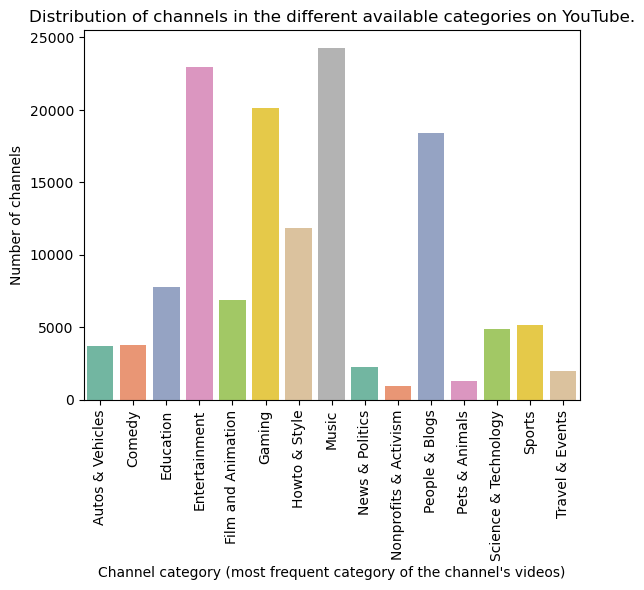

In [56]:
#distribution of categories for the channels

channels_by_category_filepath = dataset_root_path + "../generated_data/channel_count_per_category.csv"

try:  # try to read data from file
    channels_per_category = pd.read_csv(channels_by_category_filepath)
    print("Loaded data from file")
except FileNotFoundError:  # if file does not exist, generate it and save
    channels_per_category = df_channels_clean.groupby('category_cc').agg(number_of_channels=('category_cc', 'size')).reset_index()
    channels_per_category.to_csv(channels_by_category_filepath, index=False)

display(channels_per_category)


ax = sns.barplot(x="category_cc", y="number_of_channels", data=channels_per_category,hue="category_cc", palette='Set2')
plt.xticks(rotation=90)
plt.title("Distribution of channels in the different available categories on YouTube.")
plt.xlabel("Channel category (most frequent category of the channel's videos)")
plt.ylabel("Number of channels")
plt.show()

Going through chunk 0...
The first 100000 entries have been processed. 72824794 left.
2.570 secs per chunk on average. Meaning  31.188 minutes left.
Going through chunk 1...
The first 200000 entries have been processed. 72724794 left.
2.851 secs per chunk on average. Meaning  34.552 minutes left.
Going through chunk 2...
The first 300000 entries have been processed. 72624794 left.
2.677 secs per chunk on average. Meaning  32.409 minutes left.
Going through chunk 3...
The first 400000 entries have been processed. 72524794 left.
2.547 secs per chunk on average. Meaning  30.787 minutes left.
Going through chunk 4...
The first 500000 entries have been processed. 72424794 left.
2.325 secs per chunk on average. Meaning  28.061 minutes left.
Going through chunk 5...
The first 600000 entries have been processed. 72324794 left.
2.201 secs per chunk on average. Meaning  26.529 minutes left.
Going through chunk 6...
The first 700000 entries have been processed. 72224794 left.
2.093 secs per chunk

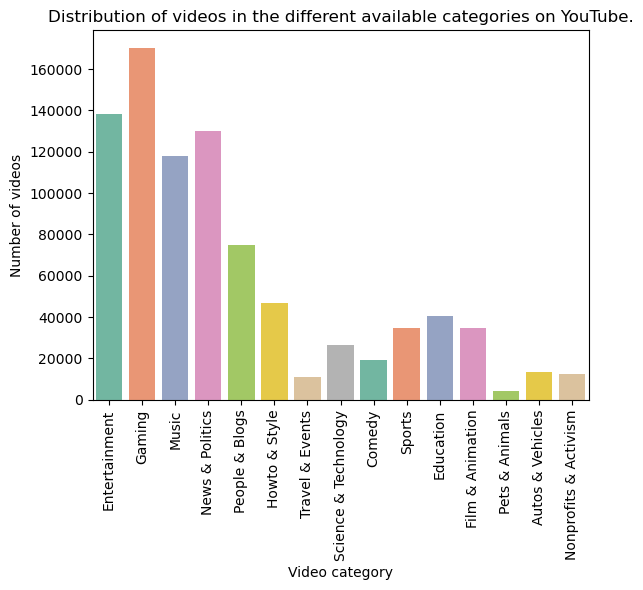

In [57]:
#distribution categories of videos over the whole (cleaned) dataset per chunck

# Define a function that processes a single chunk
def count_videos_by_category(chunk):
    
    # Count videos in each category within the chunk
    category_counts = chunk['categories'].value_counts().to_frame().T  # Get counts and transpose for one-row DataFrame
    category_counts.columns.name = None  # Remove column name for easy concatenation
    return category_counts

videos_by_category_filepath = dataset_root_path + "../generated_data/video_count_by_category.csv"

try:  # try to read the data from file
    videos_per_category_counts_total = pd.read_csv(videos_by_category_filepath)
    print("Data read from file")
except FileNotFoundError:  # otherwise, generate it and save

    # Apply the function to all chunks and get the results concatenated
    videos_per_category_counts_per_chunk = dp.run_simple_function_on_chunks_concat(
        videos_in_chunks_clean(chunksize=100000), 
        count_videos_by_category,
        print_time=(100000, 72924794)
        )

    # Sum the counts across all chunks to get the total count of videos per category
    videos_per_category_counts_total = videos_per_category_counts_per_chunk.sum().to_frame(name='total_count').reset_index()
    videos_per_category_counts_total.columns = ['category', 'total_count']

    videos_per_category_counts_total.to_csv(videos_by_category_filepath,)  # save the created dataframe so we don't have to generate it again


# Display the final distribution
print(videos_per_category_counts_total)

ax = sns.barplot(x="category", y="total_count", hue='category', legend=False, data=videos_per_category_counts_total, palette='Set2')
plt.xticks(rotation=90)
plt.title("Distribution of videos in the different available categories on YouTube.")
plt.xlabel("Video category")
plt.ylabel("Number of videos")
plt.show()

## TODO: interpretation of plots

Something like (check this, this is just from the top of my head) "we see that there are not that many News & Politics channels compared to the other categories, however there are a much larger fraction of News & Politics *videos*. Therefore, we conclude that the News & Politics channels post videos rather actively."

Here is also an idea which Mila (I think) wrote: instead of saying it goes in our way we could say , that it is already a small category which can lead to more isolation as people are less interested 
and there exists less various sources thus clustering can happen more easily 


In [58]:
# delete the datasets, as we don't need them anymore

del videos_per_category_counts_total
del channels_per_category

## Filtering the datasets to our needs

### Filtering **videos** by category 'News & Politics'

In [59]:
# filter the video dataframe to only include videos from n&p category

videos_in_news_pol_filepath = dataset_root_path + "../generated_data/videos_in_news_pol.csv"

if os.path.isfile(videos_in_news_pol_filepath):  # if the file already exists
    print("File already exists, no need to generate again.\nDelete or rename the existing file in order to regenerate it.")
else:  # if not, generate the file. The data is directly saved to a new dataframe, 
       # because it would be to big to load in memory at once
    dp.run_simple_function_on_chunks_save_csv(videos_in_chunks_clean(chunksize=100000),
                                              lambda x: x[x.categories == "News & Politics"], 
                                              filename=videos_in_news_pol_filepath,
                                              index=False,
                                              overwrite=False,  # will not overwrite existing files
                                              every=15,  # will save to the csv every 15 chunks
                                              print_time=(100000, 72924794))

Going through chunk 0...
            categories                channel_id                  crawl_date  \
1812   News & Politics  UCzWm1-4XF7AHxVUTkHCM1uw  2019-11-17 06:28:42.593675   
7514   News & Politics  UCzWLsxDD373D4tY8kN-0LGQ  2019-11-05 00:42:33.012228   
16686  News & Politics  UCzVBu6oqlrAix0oq9T2rBFg  2019-11-19 20:40:22.403775   
22303  News & Politics  UCzUV5283-l5c0oKRtyenj6Q  2019-11-22 08:47:10.520209   
22304  News & Politics  UCzUV5283-l5c0oKRtyenj6Q  2019-11-22 08:46:16.481889   
...                ...                       ...                         ...   
74162  News & Politics  UCzRBOssI9G6VN6HNP--wGFA  2019-11-16 12:32:12.445208   
74163  News & Politics  UCzRBOssI9G6VN6HNP--wGFA  2019-11-16 12:32:13.003313   
74164  News & Politics  UCzRBOssI9G6VN6HNP--wGFA  2019-11-16 12:32:13.617744   
74166  News & Politics  UCzRBOssI9G6VN6HNP--wGFA  2019-11-16 12:32:14.823963   
74167  News & Politics  UCzRBOssI9G6VN6HNP--wGFA  2019-11-16 12:32:15.396711   

              

In [60]:
# load the (large) csv file that was just written, containing the videos in news and politics, in chunks, 
# and print the head of the first chunk and the shape of each chunk (this is just to show that it works)

print("News and politics videos:\n")

total_length = 0
for i, chunk in enumerate(pd.read_csv(dataset_root_path + "/../generated_data/videos_in_news_pol.csv", chunksize=100000)):
    if i == 0:
        print(f"Head of chunk 0: ")
        display(chunk.head())
        print("The shapes of all chunks:")

    print(f"Shape of chunk number {i}: {chunk.shape}")
    total_length += chunk.shape[0]

print(f"In total {total_length} rows, which takes up {i+1} chunks.")
del chunk

print(f"{gc.collect()} garbages collected.")

News and politics videos:

Head of chunk 0: 


,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count
0,News & Politics,UCzWm1-4XF7AHxVUTkHCM1uw,2019-11-17 06:28:42.593675,retrogamer3.com,16.0,dfa8RRkKoa4,9251,25.0,"RetroGamer3,Live Stream,politics,Trump",Retrogamer3 Political Stream,2018-08-23 00:00:00,478.0
1,News & Politics,UCzWLsxDD373D4tY8kN-0LGQ,2019-11-05 00:42:33.012228,What are the forces at work that have created ...,0.0,_dIIEMvH86k,309,9.0,"NWO,Ebola,Ukraine,Mainstream,Media,Pyschology",Adam Curtis describes the Surkow Strategy of M...,2015-01-04 00:00:00,865.0
2,News & Politics,UCzVBu6oqlrAix0oq9T2rBFg,2019-11-19 20:40:22.403775,Social Media:\n\nFacebook.com/thebookoflaura\n...,89.0,eWXefhNB2po,707,625.0,"michael jackson,lyrics,music video,court,child...",my thoughts on the michael jackson documentary.,2019-04-24 00:00:00,12780.0
3,News & Politics,UCzUV5283-l5c0oKRtyenj6Q,2019-11-22 08:47:10.520209,👕 Order your shirts here: https://Teespring.co...,195.0,MBgzne7djFU,378,47027.0,"Funny,Entertainment,Fun,Laughing,Educational,L...",Elizabeth Warren Gets a Big Surprise at the Ai...,2019-10-03 00:00:00,374711.0
4,News & Politics,UCzUV5283-l5c0oKRtyenj6Q,2019-11-22 08:46:16.481889,👕 Order your shirts here: https://Teespring.co...,114.0,AbH3pJnFgY8,278,36384.0,"Funny,Entertainment,Fun,Laughing,Educational,L...",No More Twitter? 😂,2019-10-02 00:00:00,245617.0


The shapes of all chunks:
Shape of chunk number 0: (100000, 12)
Shape of chunk number 1: (30094, 12)
In total 130094 rows, which takes up 2 chunks.
362 garbages collected.


### Filtering **channels** by category News & Politics

In [61]:
#filter channels dataset to only include n&p

# Note: because the channel dataset is much smaller than the video dataset, we don't need to worry about chunks here
# Also, the results can be saved in a single file without a problem.

channels_news_pol_filepath = dataset_root_path + "../generated_data/channels_in_news_pol.csv"

try:
    df_channels_news_pol = pd.read_csv(channels_news_pol_filepath)
    print("Read data from file")
except FileNotFoundError:
    df_channels_news_pol = df_channels_clean[df_channels_clean.category_cc == "News & Politics"]
    df_channels_news_pol.to_csv(channels_news_pol_filepath, index=False)

In [62]:
display(df_channels_news_pol.head())
display(df_channels_news_pol.shape)

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
129,News & Politics,2006-08-26,UCttspZesZIDEwwpVIgoZtWQ,IndiaTV,15177282,139814,199.0,2.087
133,News & Politics,2012-06-01,UCRWFSbif-RFENbBrSiez1DA,ABP NEWS,16274836,129027,207.0,2.087
212,News & Politics,2017-03-03,UCmphdqZNmqL72WJ2uyiNw5w,ABP NEWS HINDI,10800000,51298,340.0,2.087
268,News & Politics,2015-03-23,UCx8Z14PpntdaxCt2hakbQLQ,The Lallantop,9120000,9423,438.0,2.087
337,News & Politics,2007-06-19,UCIvaYmXn910QMdemBG3v1pQ,Zee News,9280000,102648,549.0,2.087


(2263, 8)

### Checking whether all videos in News and Politics are also uploaded by a channel in that category

In [63]:
# check if all videos we found in news&pol are also published by a channel in category n&p

videos_news_pol__channel_not_news_pol_filepath = dataset_root_path + "../generated_data/videos_in_news_pol__channel_not_in_news_pol.csv"

try:
    df_videos_news_pol__channel_not_news_pol = pd.read_csv(videos_news_pol__channel_not_news_pol_filepath)
    print("Read data from file")
except FileNotFoundError:
    # go through the large file of news and politics videos in chunks, 
    # and extract all videos which were not uploaded by a News & Politics channel

    df_videos_news_pol__channel_not_news_pol = dp.run_simple_function_on_chunks_concat(
        reader=pd.read_csv(dataset_root_path + "../generated_data/videos_in_news_pol.csv", chunksize=100000),
        fct=lambda chunk: chunk[np.logical_not(chunk.channel_id.isin(df_channels_news_pol.channel))],
        print_time=True
        )

    # save the resuls to a csv
    df_videos_news_pol__channel_not_news_pol.to_csv(videos_news_pol__channel_not_news_pol_filepath, index=False)

        
display(df_videos_news_pol__channel_not_news_pol.head())
display(df_videos_news_pol__channel_not_news_pol.shape)



Going through chunk 0...
1.212 secs per chunk on average.
Going through chunk 1...
0.905 secs per chunk on average.


,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count
0,News & Politics,UCzWm1-4XF7AHxVUTkHCM1uw,2019-11-17 06:28:42.593675,retrogamer3.com,16.0,dfa8RRkKoa4,9251,25.0,"RetroGamer3,Live Stream,politics,Trump",Retrogamer3 Political Stream,2018-08-23 00:00:00,478.0
1,News & Politics,UCzWLsxDD373D4tY8kN-0LGQ,2019-11-05 00:42:33.012228,What are the forces at work that have created ...,0.0,_dIIEMvH86k,309,9.0,"NWO,Ebola,Ukraine,Mainstream,Media,Pyschology",Adam Curtis describes the Surkow Strategy of M...,2015-01-04 00:00:00,865.0
2,News & Politics,UCzVBu6oqlrAix0oq9T2rBFg,2019-11-19 20:40:22.403775,Social Media:\n\nFacebook.com/thebookoflaura\n...,89.0,eWXefhNB2po,707,625.0,"michael jackson,lyrics,music video,court,child...",my thoughts on the michael jackson documentary.,2019-04-24 00:00:00,12780.0
1033,News & Politics,UCzTmNzBxLEHbpZNOCpUTWbA,2019-11-03 04:38:01.617657,A young man is living a normal life with no ca...,16.0,ck6Yl8TNoWs,1257,452.0,"JoiRida,Cheatham,JoiRidaCheatham,Accepted,Detr...",Accepted - Award Winning Short Film,2013-10-13 00:00:00,27366.0
1034,News & Politics,UCzTmNzBxLEHbpZNOCpUTWbA,2019-11-03 04:38:06.565138,Short Film,1.0,tjUajxZAIZ8,422,15.0,"Joi.Rida,Cheatham,joiridacheatham,dread,loc,up...",JoiRida Twin Visit (Introducing Jive Viper),2010-03-04 00:00:00,987.0


(7892, 12)

**We see that indeed, not all videos in the news and politics category belong to a channel in this category!**
A google search shows that apparently, you don't have to have the same category for all videos, but you set a "default" channel category which will be used for videos if you don't change it manually. Also, you can probably change the default category after a while if you want.

This is the reason why most of the news&pol videos are uploaded by a news&pol channel, but not all.

In the paper about the dataset, the authors say that the channel category is actually the "most frequent category". We believe that the video categories are the most relevant, as they are the 'true' categories.

### Filtering the N&P videos by a list of channels

In [64]:
# define variables for the channel ids of CNN, ABC, BBC, Al Jazeera English and Fox
channel_id_cnn = "UCupvZG-5ko_eiXAupbDfxWw",  # CNN
channel_id_abc = "UCBi2mrWuNuyYy4gbM6fU18Q",  # ABC News
channel_id_bbc = "UC16niRr50-MSBwiO3YDb3RA",  # BBC News
channel_id_aje = "UCNye-wNBqNL5ZzHSJj3l8Bg",  # Al Jazeera English
channel_id_fox = "UCXIJgqnII2ZOINSWNOGFThA",  # Fox News

selected_channel_ids = [channel_id_cnn,
                        channel_id_abc,
                        channel_id_bbc,
                        channel_id_aje,
                        channel_id_fox]

In [65]:
# form the filtered N&P videos dataframe, keep those posted by channels manually selected (here CNN, ABC News, BBC News, Al Jazeera English and Fox News)

videos_news_pol_manual_selection_filepath = dataset_root_path + "../generated_data/videos_from_news_pol_from_selected_channels.csv"

try:
    df_videos_news_pol_manually_selected = pd.read_csv(videos_news_pol_manual_selection_filepath)
    print("Read data from file")
except FileNotFoundError:
    # go through the large file with videos in news and politics, 
    # and select those videos which are uploaded by one of our selected channels

    df_videos_news_pol_manually_selected = dp.run_simple_function_on_chunks_concat(
        reader=pd.read_csv(dataset_root_path + "../generated_data/videos_in_news_pol.csv", 
                           chunksize=100000),
        fct=lambda chunk: chunk[chunk.channel_id.isin(selected_channel_ids)],
        print_time=True)
    
    # save the results to a csv
    df_videos_news_pol_manually_selected.to_csv(videos_news_pol_manual_selection_filepath, index=False)

display(df_videos_news_pol_manually_selected.head())
display(df_videos_news_pol_manually_selected.shape)

Going through chunk 0...
1.186 secs per chunk on average.
Going through chunk 1...
0.886 secs per chunk on average.


,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count


(0, 12)

### Split the selected news & pol **videos** in the five channels

In [66]:
# filter the video dataset to get only videos from each of our selected channels

# define the filepaths for the data
videos_news_pol_cnn_filepath = dataset_root_path + "../generated_data/videos_news_pol_cnn.csv"
videos_news_pol_abc_filepath = dataset_root_path + "../generated_data/videos_news_pol_abc.csv"
videos_news_pol_bbc_filepath = dataset_root_path + "../generated_data/videos_news_pol_bbc.csv"
videos_news_pol_aje_filepath = dataset_root_path + "../generated_data/videos_news_pol_aje.csv"
videos_news_pol_fox_filepath = dataset_root_path + "../generated_data/videos_news_pol_fox.csv"

# for each of the 5 channels...
# CNN
try:  # ... try to load the data from file
    df_videos_news_pol_cnn = pd.read_csv(videos_news_pol_cnn_filepath)
    print("Data read from file")
except FileNotFoundError:  # otherwise, generate it and save
    df_videos_news_pol_cnn = df_videos_news_pol_manually_selected.loc[
        df_videos_news_pol_manually_selected.channel_id == channel_id_cnn]
    df_videos_news_pol_cnn.to_csv(videos_news_pol_cnn_filepath, index=False)

# ABC News
try:
    df_videos_news_pol_abc = pd.read_csv(videos_news_pol_cnn_filepath)
    print("Data read from file")
except FileNotFoundError:
    df_videos_news_pol_abc = df_videos_news_pol_manually_selected.loc[
        df_videos_news_pol_manually_selected.channel_id == channel_id_abc]
    df_videos_news_pol_abc.to_csv(videos_news_pol_abc_filepath, index=False)
    
# BBC News
try:
    df_videos_news_pol_bbc = pd.read_csv(videos_news_pol_cnn_filepath)
    print("Data read from file")
except FileNotFoundError:
    df_videos_news_pol_bbc = df_videos_news_pol_manually_selected.loc[
        df_videos_news_pol_manually_selected.channel_id == channel_id_bbc]
    df_videos_news_pol_bbc.to_csv(videos_news_pol_bbc_filepath, index=False)

# Al Jazeera English
try:
    df_videos_news_pol_aje = pd.read_csv(videos_news_pol_cnn_filepath)
    print("Data read from file")
except FileNotFoundError:
    df_videos_news_pol_aje = df_videos_news_pol_manually_selected.loc[
        df_videos_news_pol_manually_selected.channel_id == channel_id_aje]
    df_videos_news_pol_aje.to_csv(videos_news_pol_aje_filepath, index=False)

# Fox News
try:
    df_videos_news_pol_fox = pd.read_csv(videos_news_pol_cnn_filepath)
    print("Data read from file")
except FileNotFoundError:
    df_videos_news_pol_fox = df_videos_news_pol_manually_selected.loc[
        df_videos_news_pol_manually_selected.channel_id == channel_id_fox]
    df_videos_news_pol_fox.to_csv(videos_news_pol_fox_filepath, index=False)

Data read from file
Data read from file
Data read from file
Data read from file


### Filtering **comments** of the 5 channels using n&p video ids obtained above

In [77]:
# get comments on (n&p) videos from our selected channels using the ids from filtered video dataset from the selected channels

comments_news_pol_selected_channels_filepath = dataset_root_path + "../generated_data/comments_news_pol_selected_channels.csv"

try:
    df_comments_news_pol_manually_selected = pd.read_csv(comments_news_pol_selected_channels_filepath)
    print("Read data from file")
except FileNotFoundError:

    # get all the comments made on a video uploaded by one of our selected channels
    df_comments_news_pol_manually_selected = dp.run_simple_function_on_chunks_concat(
        comments_in_chunks_clean(chunksize=1000000), 
        lambda comment_df: comment_df.loc[comment_df['video_id'].isin(df_videos_news_pol_manually_selected.display_id)],
        print_time=(1000000, 8600000000))
    display(df_videos_news_pol_manually_selected[["display_id", "channel_id"]])
    # merge it with the video data of the selected channels, to get the channel id directly in the comment df
    df_comments_news_pol_manually_selected.merge(
        df_videos_news_pol_manually_selected[["display_id", "channel_id"]], 
        left_on="video_id", right_on="display_id")
    # save as csv
    df_comments_news_pol_manually_selected.to_csv(comments_news_pol_selected_channels_filepath, index=False)

Going through chunk 0...
The first 1000000 entries have been processed. 8599000000 left.
0.776 secs per chunk on average. Meaning  111.261 minutes left.
Going through chunk 1...
The first 2000000 entries have been processed. 8598000000 left.
0.730 secs per chunk on average. Meaning  104.595 minutes left.
Going through chunk 2...
The first 3000000 entries have been processed. 8597000000 left.
0.679 secs per chunk on average. Meaning  97.323 minutes left.
Going through chunk 3...
The first 4000000 entries have been processed. 8596000000 left.
0.652 secs per chunk on average. Meaning  93.368 minutes left.
Going through chunk 4...
The first 5000000 entries have been processed. 8595000000 left.
0.651 secs per chunk on average. Meaning  93.251 minutes left.
Going through chunk 5...
The first 6000000 entries have been processed. 8594000000 left.
0.643 secs per chunk on average. Meaning  92.142 minutes left.
Going through chunk 6...
The first 7000000 entries have been processed. 8593000000 lef

,display_id,channel_id


In [74]:
display(df_comments_news_pol_manually_selected.head())
display(df_comments_news_pol_manually_selected.shape)

,author,video_id,likes,replies


(0, 4)

### Split in the five channels

In [75]:
# define the file paths for the files for comments from each of the channels

comments_news_pol_selected_channels_filepaths = [
    dataset_root_path + "../generated_data/comments_news_pol_" + channel + ".csv" 
    for channel in ["cnn", "abc", "bbc", "aje", "fox"]
    ]

# check if all of the files already exist
if np.all([os.path.isfile(filepath) for filepath in comments_news_pol_selected_channels_filepaths]):
    df_comments_news_pol_cnn = pd.read_csv(comments_news_pol_selected_channels_filepaths[0])
    df_comments_news_pol_abc = pd.read_csv(comments_news_pol_selected_channels_filepaths[1])
    df_comments_news_pol_bbc = pd.read_csv(comments_news_pol_selected_channels_filepaths[2])
    df_comments_news_pol_aje = pd.read_csv(comments_news_pol_selected_channels_filepaths[3])
    df_comments_news_pol_fox = pd.read_csv(comments_news_pol_selected_channels_filepaths[4])
    print("Read 5 dfs from file")
else:
    # group the comments by channel
    df_comments_news_pol_manually_selected_grouped = df_comments_news_pol_manually_selected.groupby("channel_id")
    
    # save the groups to new dfs
    (df_comments_news_pol_cnn,
     df_comments_news_pol_abc,
     df_comments_news_pol_bbc,
     df_comments_news_pol_aje,
     df_comments_news_pol_fox) = (df_comments_news_pol_manually_selected_grouped.get_group(x) 
                                  for x in df_comments_news_pol_manually_selected_grouped)
    
    # save the new dfs to csv
    df_comments_news_pol_cnn.to_csv(comments_news_pol_selected_channels_filepaths[0], index=False)
    df_comments_news_pol_cnn.to_csv(comments_news_pol_selected_channels_filepaths[1], index=False)
    df_comments_news_pol_cnn.to_csv(comments_news_pol_selected_channels_filepaths[2], index=False)
    df_comments_news_pol_cnn.to_csv(comments_news_pol_selected_channels_filepaths[3], index=False)
    df_comments_news_pol_cnn.to_csv(comments_news_pol_selected_channels_filepaths[4], index=False)

KeyError: 'channel_id'

### Plots 
1. Using the previous functions, plot the tot nb of comments and/or subscribers in the selected channels (all on same plot).

2. For each channel, plot the distribution of comments for all the users.

### Plot total nomber of users and comments in the 5 channels

## Selecting the cluster of users in a specific channel 

(flexible function where you give the threshold of x comments)


In [ ]:
#returns df with users_id and total number of comments made in a specific channel
def get_metadata_commenters(comment_data: pd.DataFrame, threshold: int = 0) -> pd.DataFrame:
    """
    Generates a dataframe with comment count and number of videos commented under, 
    for each person that has commented.
    Works on any df containing a set of comment data 
    (e.g., filtered to contain only comments under videos from a certain channel).

    Args:
        comment_data: df containing the comments for which to generate metadata
        threshold: (default 0) only commenters with more than this amount of comments 
            will be included in the dataframe.

    Returns:
        df with columns author, number of comments and number of videos
    """

    metadata_commenters = comment_data.groupby('author').agg(number_of_comments=('author', 'size')).reset_index()
    metadata_commenters['number_of_videos']= comment_data.groupby('author')['video_id'].nunique().values
    
    #keep users that wrote more than <threshold> comments 
    metadata_commenters=metadata_commenters[metadata_commenters['number_of_comments']>=threshold]
    return metadata_commenters

#test with threshold=0
metadata_commenters_news_pol_cnn = get_metadata_commenters(df_comments_news_pol_cnn,0)

metadata_commenters_news_pol_cnn.to_csv(dataset_root_path + "../generated_data/commenter_metadata_news_pol_cnn.csv")

display(metadata_commenters_news_pol_cnn.head())
display(metadata_commenters_news_pol_cnn.shape)

,author,number_of_comments,number_of_videos
0,453667,1,1
1,468696,1,1
2,594074,1,1


### Plots
1. Venn diagram with clusters of the channels and underline overlaps

# Deeper analysis and statistics
Todo: 
create dataset of all comments which are under a video in the news and politics category

use this dataset to get the list of videos under which each of the users we found (above) have made a comment

for each pair of users, calculate "number of videos in common (under which both have commented) / min number of videos both users have commented on"
(example: mila commented on 10 videos, andreas on 100 videos, they have 8 videos they both commented on, so the value we calculate is 8/10 = 0.8)
